In [1]:
%load_ext autoreload
%autoreload 2

# Bayesian Optimization for RNA circuit topologies

Iterative Bayesian optimization using botorch to find optimal circuit parameters for adaptability. This mirrors the genetic algorithm sampling loop in `32_genetic_algos` but replaces the sampling strategy with BO using a Gaussian Process surrogate.


In [2]:
import os
import warnings
from functools import partial
from typing import Tuple

import diffrax as dfx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.physical import (
	eqconstant_to_rates,
	equilibrium_constant_reparameterisation,
)
from synbio_morpher.utils.modelling.solvers import (
	get_diffrax_solver,
	make_stepsize_controller,
	simulate_steady_states,
)
from synbio_morpher.utils.results.analytics.timeseries import compute_adaptability_full


warnings.filterwarnings("ignore")

jax.config.update("jax_platform_name", "gpu")

np.random.seed(0)
torch.manual_seed(0)
jax.devices()


top_write_dir = os.path.join("data", "33_bo")
os.makedirs(top_write_dir, exist_ok=True)

# Set up circuits and BO settings

In [3]:
def make_species_bound(species_unbound):
	return sorted(
		set(
			flatten_listlike(
				[["-".join(sorted([x, y])) for x in species_unbound] for y in species_unbound]
			)
		)
	)


# RNA circuit settings
species_unbound = ["RNA_0", "RNA_1", "RNA_2"]
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ["RNA_0"]
species_output = ["RNA_2"]
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 1  # 500  # 
ts = np.linspace(t0, t1, 500)
tmax = 1  # 2000  # 
dt0 = 0.0001
dt1 = 0.5
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = "Tsit5"
stepsize_controller = "adaptive"
threshold_steady_state = 0.01
batch_size = 8000
save_steps = 100
save_steps_uselog = True

# BO parameters
total_steps = 20
n_init = 10000  # Total samples in initial design
bo_batch_size = 500
energy_min, energy_max = -30.0, 0.0

run_bo = True


N0 = 100

inputs = np.array(
	[
		[2, 0, 0, 0, 0, 0, 0, 0, 0],
		[1, 1, 0, 0, 0, 0, 0, 0, 0],
		[1, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 2, 0, 0, 0, 0, 0, 0, 0],
		[0, 1, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 2, 0, 0, 0, 0, 0, 0],
	],
	dtype=np.float64,
)
outputs = np.array(
	[
		[0, 0, 0, 1, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 1, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 1, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 1, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 1, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 1],
	],
	dtype=np.float64,
)

fn_save = os.path.join(top_write_dir, "bayesian_optimization_results.csv")

In [4]:
# Baseline forward rates (kept constant, as in the GA loop)
_n_params = len(np.tril_indices(len(species_unbound))[0])
_base_energies = np.random.rand(1, _n_params)
_base_energies = np.interp(_base_energies, (_base_energies.min(), _base_energies.max()), (energy_min, energy_max))
_base_eq = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(_base_energies)
_base_forward_rates, _ = eqconstant_to_rates(_base_eq, k_a)
forward_rates = _base_forward_rates[0]


# BO functions

In [5]:
def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
	def join_results(xs, xsb):
		if xs is None:
			xs = xsb
		else:
			xs = jnp.concatenate([xs, xsb], axis=0)
		return xs

	ys0, ts0, ys1, ts1 = [None] * 4
	for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
		i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
		print(f"Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}")
		y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
		ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)

		ys0 = join_results(ys0, ys0b)
		ts0 = join_results(ts0, ts0b)
		ys1 = join_results(ys1, ys1b)
		ts1 = join_results(ts1, ts1b)

	return ys0, ts0, ys1, ts1


def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
	ys0, ts0 = simulate_steady_states(
		y0=y00,
		total_time=tmax,
		sim_func=sim_func,
		t0=t0,
		t1=t1,
		threshold=threshold,
		reverse_rates=reverse_rates,
	)
	y01 = np.array(ys0[:, -1])
	y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
	ys1, ts1 = simulate_steady_states(
		y0=y01,
		total_time=tmax,
		sim_func=sim_func,
		t0=t0,
		t1=t1,
		threshold=threshold,
		reverse_rates=reverse_rates,
	)
	return ys0, ts0, ys1, ts1


def evaluate_energies(
	energies: np.ndarray,
	sim_func,
	t0,
	t1,
	tmax,
	batch_size,
	threshold,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
	"""Evaluate energies and return objective score and raw metrics."""

	y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)], dtype=np.float32)
	y00 = np.repeat(y00, repeats=len(energies), axis=0)

	eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
	_, reverse_rates = eqconstant_to_rates(eqconstants, k_a)

	ys0, _, ys1, _ = simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold)

	adaptability, sensitivity, precision = jax.vmap(
		partial(compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1)
	)(ys0, ys1)

	# Objective: maximize adaptability on output species
	score = np.nanmax(np.array(adaptability)[:, idxs_output], axis=1)

	return score, np.array(adaptability), np.array(sensitivity), np.array(precision)

# Run

In [6]:
if run_bo:
	# GPU device for data storage, CPU device for botorch/GPyTorch
	# gpu_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	cpu_device = torch.device("cpu")

	# Set up simulator
	sim_func = jax.vmap(
		partial(
			bioreaction_sim_dfx_expanded,
			t0=t0,
			t1=t1,
			dt0=dt0,
			forward_rates=forward_rates,
			inputs=inputs,
			outputs=outputs,
			solver=get_diffrax_solver(sim_method),
			saveat=dfx.SaveAt(
				ts=np.logspace(np.log10(t0 + 1), np.log10(t1), save_steps, base=10, endpoint=True) - 1.0
			),
			max_steps=16**5,
			stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller),
		)
	)

	n_params = len(np.tril_indices(len(species_unbound))[0])

	# Initial random design
	init_energies = np.random.rand(n_init, n_params)
	init_energies = np.interp(init_energies, (init_energies.min(), init_energies.max()), (energy_min, energy_max))

	init_scores, init_adaptability, init_sensitivity, init_precision = evaluate_energies(
		init_energies, sim_func, t0, t1, tmax, batch_size, threshold_steady_state
	)

	train_x = torch.tensor(init_energies, dtype=torch.double, device=cpu_device)
	train_y = torch.tensor(init_scores, dtype=torch.double, device=cpu_device).unsqueeze(-1)

	all_records = []
	for i in range(len(init_energies)):
		all_records.append(
			{
				"Step": 0,
				"Is init": True,
				"Objective": float(init_scores[i]),
				"Adaptability": init_adaptability[i, idxs_output].tolist(),
				"Sensitivity": init_sensitivity[i, idxs_output].tolist(),
				"Precision": init_precision[i, idxs_output].tolist(),
				"Params energy": init_energies[i].tolist(),
			}
		)

	bounds = torch.tensor(
		[[energy_min] * n_params, [energy_max] * n_params], dtype=torch.double, device=cpu_device
	)

	for step in range(1, total_steps + 1):
		print(f"\n\nStarting BO iteration {step} out of {total_steps}\n\n")

		# Ensure tensors are on CPU for botorch/GPyTorch operations
		train_x_cpu = train_x.to(cpu_device)
		# train_y_cpu = train_y.to(cpu_device)
		train_y_cpu = torch.ones_like(train_y)  # Free up GPU memory
		
		model = SingleTaskGP(train_x_cpu, train_y_cpu)
		mll = ExactMarginalLogLikelihood(model.likelihood, model)
		fit_gpytorch_mll(mll)

		best_f = train_y_cpu.max()
		acq = ExpectedImprovement(model=model, best_f=best_f)

		bounds_cpu = bounds.to(cpu_device)
		candidate, _ = optimize_acqf(
			acq_function=acq,
			bounds=bounds_cpu,
			q=bo_batch_size,
			num_restarts=10,
			raw_samples=128,
		)

		cand_np = candidate.detach().cpu().numpy()
		cand_scores, cand_adaptability, cand_sensitivity, cand_precision = evaluate_energies(
			cand_np, sim_func, t0, t1, tmax, batch_size, threshold_steady_state
		)

		new_x = torch.tensor(cand_np, dtype=torch.double, device=cpu_device)
		new_y = torch.tensor(cand_scores, dtype=torch.double, device=cpu_device).unsqueeze(-1)

		train_x = torch.cat([train_x, new_x], dim=0)
		train_y = torch.cat([train_y, new_y], dim=0)

		for i in range(len(cand_np)):
			all_records.append(
				{
					"Step": step,
					"Is init": False,
					"Objective": float(cand_scores[i]),
					"Adaptability": cand_adaptability[i, idxs_output].tolist(),
					"Sensitivity": cand_sensitivity[i, idxs_output].tolist(),
					"Precision": cand_precision[i, idxs_output].tolist(),
					"Params energy": cand_np[i].tolist(),
				}
			)

		if step % max(1, total_steps // 5) == 0:
			df_step = pd.DataFrame(all_records)
			df_step.to_csv(fn_save, index=False)

	df = pd.DataFrame(all_records)
	df.to_csv(fn_save, index=False)

	if len(df) > 0:
		plt.figure(figsize=(8, 4))
		sns.lineplot(data=df, x="Step", y="Objective", errorbar=None)
		plt.title("Best objective over BO steps")
		plt.tight_layout()
		plt.savefig(os.path.join(top_write_dir, "bo_objective_over_time.png"), dpi=300)


Simulating batch 0: 0 to 8000 / 10000
Done:  0:00:02.281265
Done:  0:00:01.559411
Simulating batch 1: 8000 to 10000 / 10000
Done:  0:00:01.293413
Done:  0:00:01.137063


Starting BO iteration 1 out of 20




AssertionError: Expected X to be `batch_shape x q=1 x d`, but got X with shape torch.Size([128, 500, 6]).

# Visualise

In [ ]:
df_loaded = pd.read_csv(fn_save)
for k in ['Adaptability', 'Sensitivity', 'Precision']:
    df_loaded[k] = df_loaded[k].apply(lambda x: np.float64(x.strip('[]')))
df_loaded['Log sensitivity'] = np.log10(df_loaded['Sensitivity'])
df_loaded['Log precision'] = np.log10(df_loaded['Precision'])

In [ ]:
df_loaded

,Step,Is init,Objective,Adaptability,Sensitivity,Precision,Params energy,Log sensitivity,Log precision
0,0,True,597.798340,597.798340,0.000035,34176.648438,"[-16.873316707823264, -3.246455313031717, -1.0...",-4.451388,4.533729
1,0,True,771.276245,771.276245,0.140177,7.752187,"[-12.959226339731167, -2.2316502908136258, -27...",-0.853323,0.889424
2,0,True,699.064087,699.064087,0.002350,532.364685,"[-6.655264933205245, -3.8993425855381503, -0.6...",-2.628895,2.726209
3,0,True,750.032959,750.032959,0.037266,26.946697,"[-26.45360558641188, -10.80272874832075, -25.7...",-1.428686,1.430506
4,0,True,785.803467,785.803467,0.413406,2.418932,"[-22.064755262387376, -6.7729679013526045, -16...",-0.383624,0.383624
...,...,...,...,...,...,...,...,...,...
5015,16,False,779.457275,779.457275,0.257594,3.882084,"[-8.923719869926572, -3.652192046865821, -8.75...",-0.589065,0.589065
5016,17,False,795.752747,795.752747,0.918894,1.088265,"[-14.451794028282166, -12.669832315295935, -27...",-0.036735,0.036734
5017,18,False,699.602051,699.602051,0.002523,396.346130,"[-6.952175293117762, -22.360556311905384, -25....",-2.598075,2.598075
5018,19,False,773.357727,773.357727,0.166665,6.041286,"[-7.6463656313717365, -10.122040919959545, -10...",-0.778155,0.781129


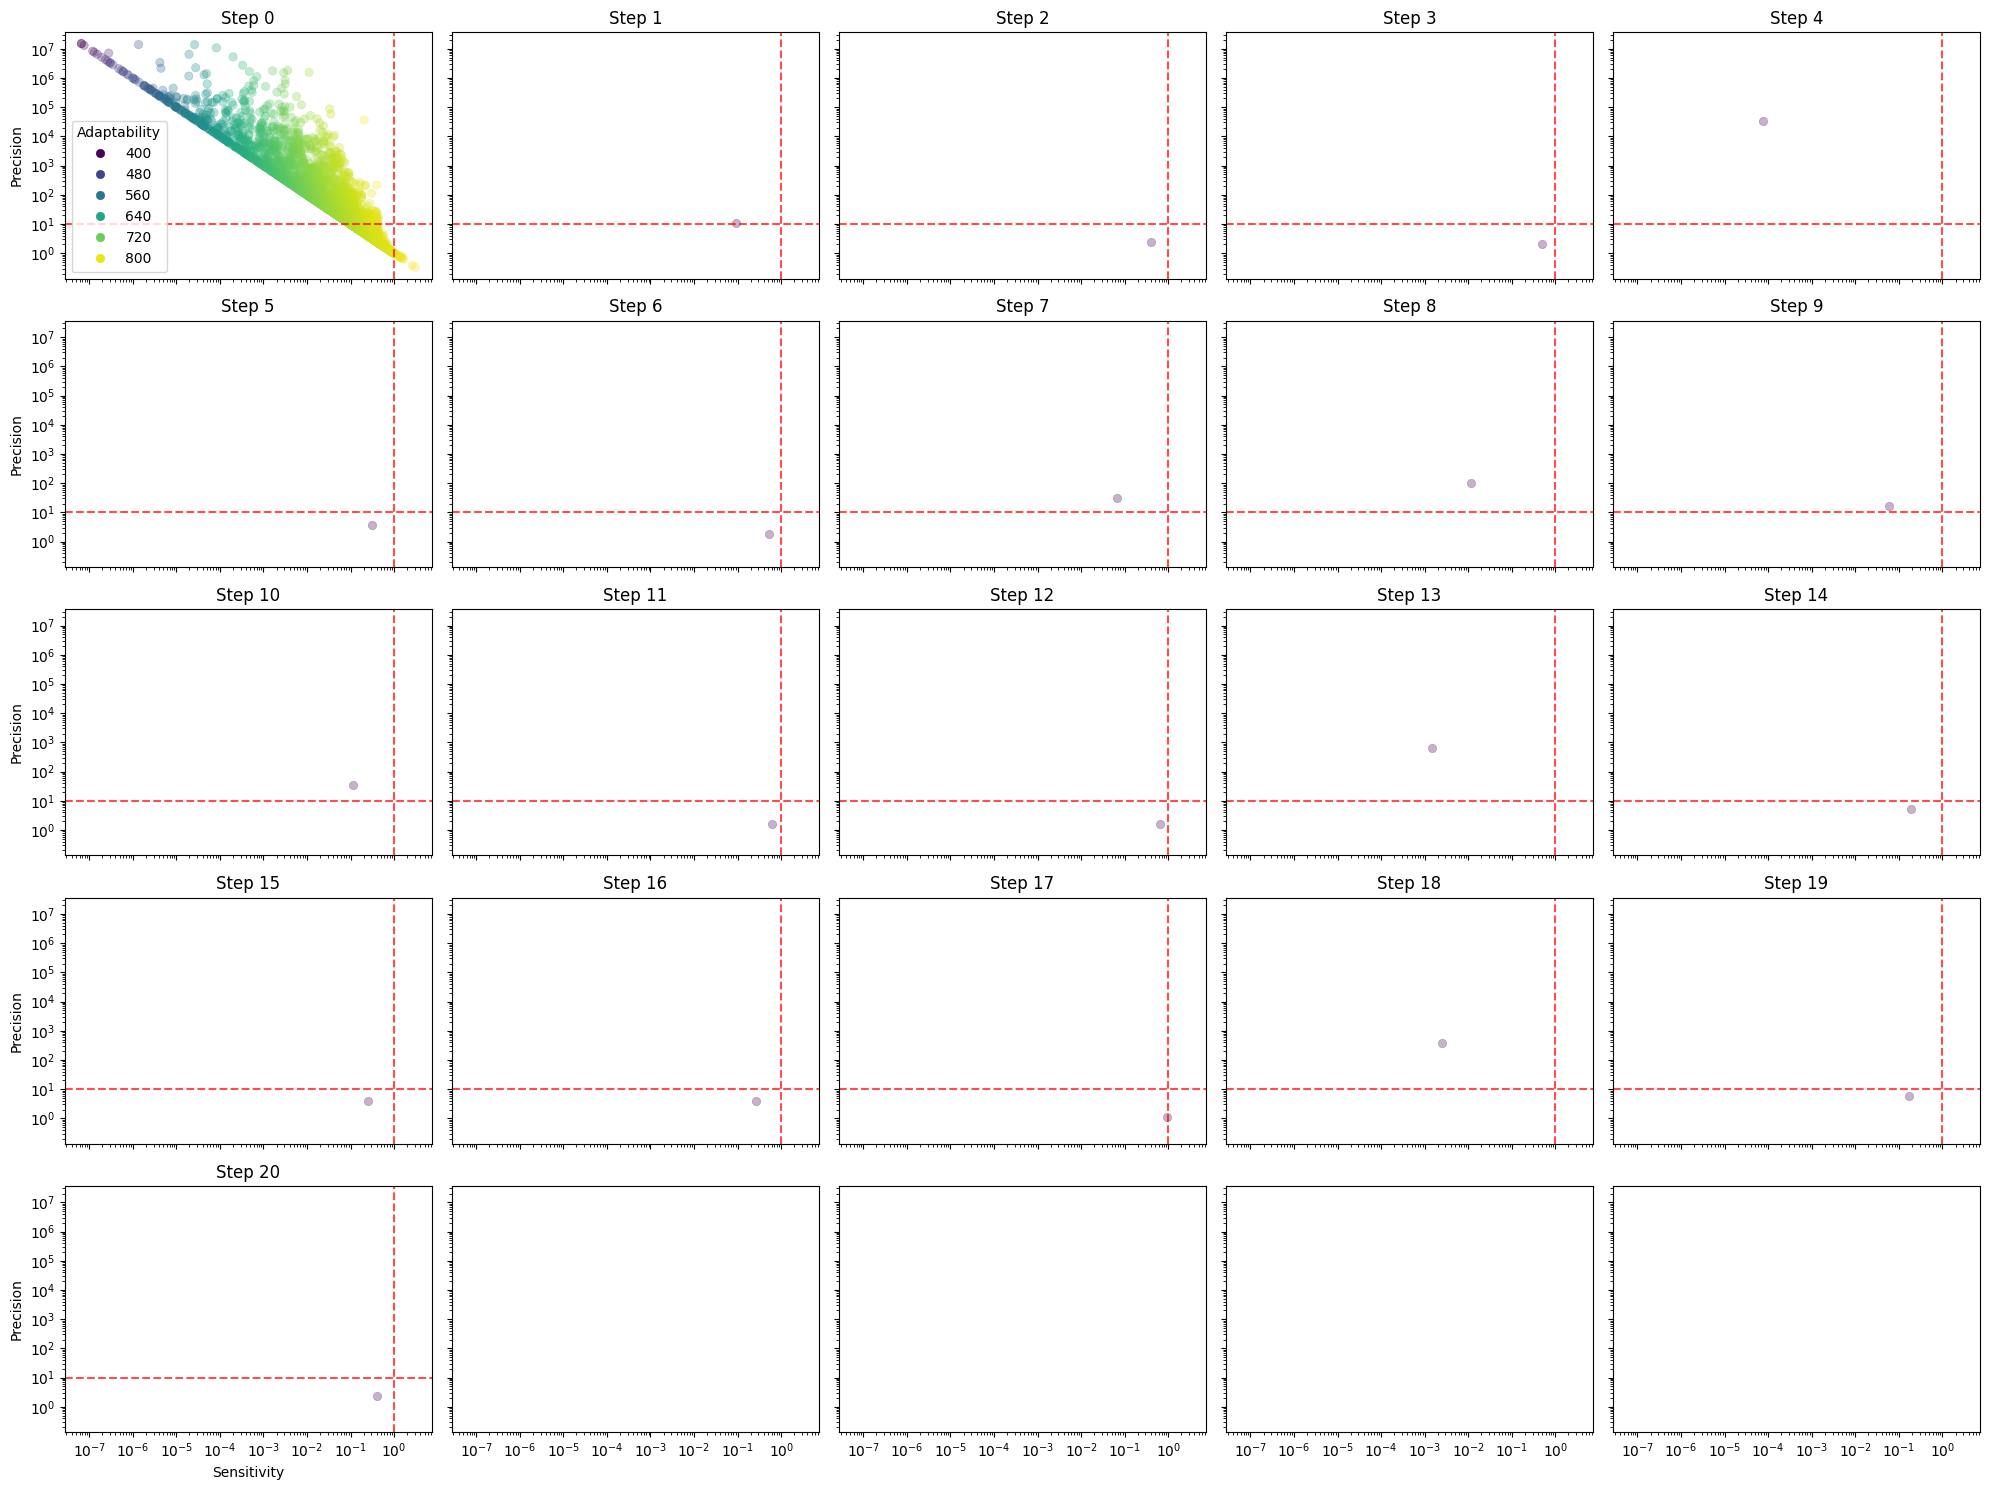

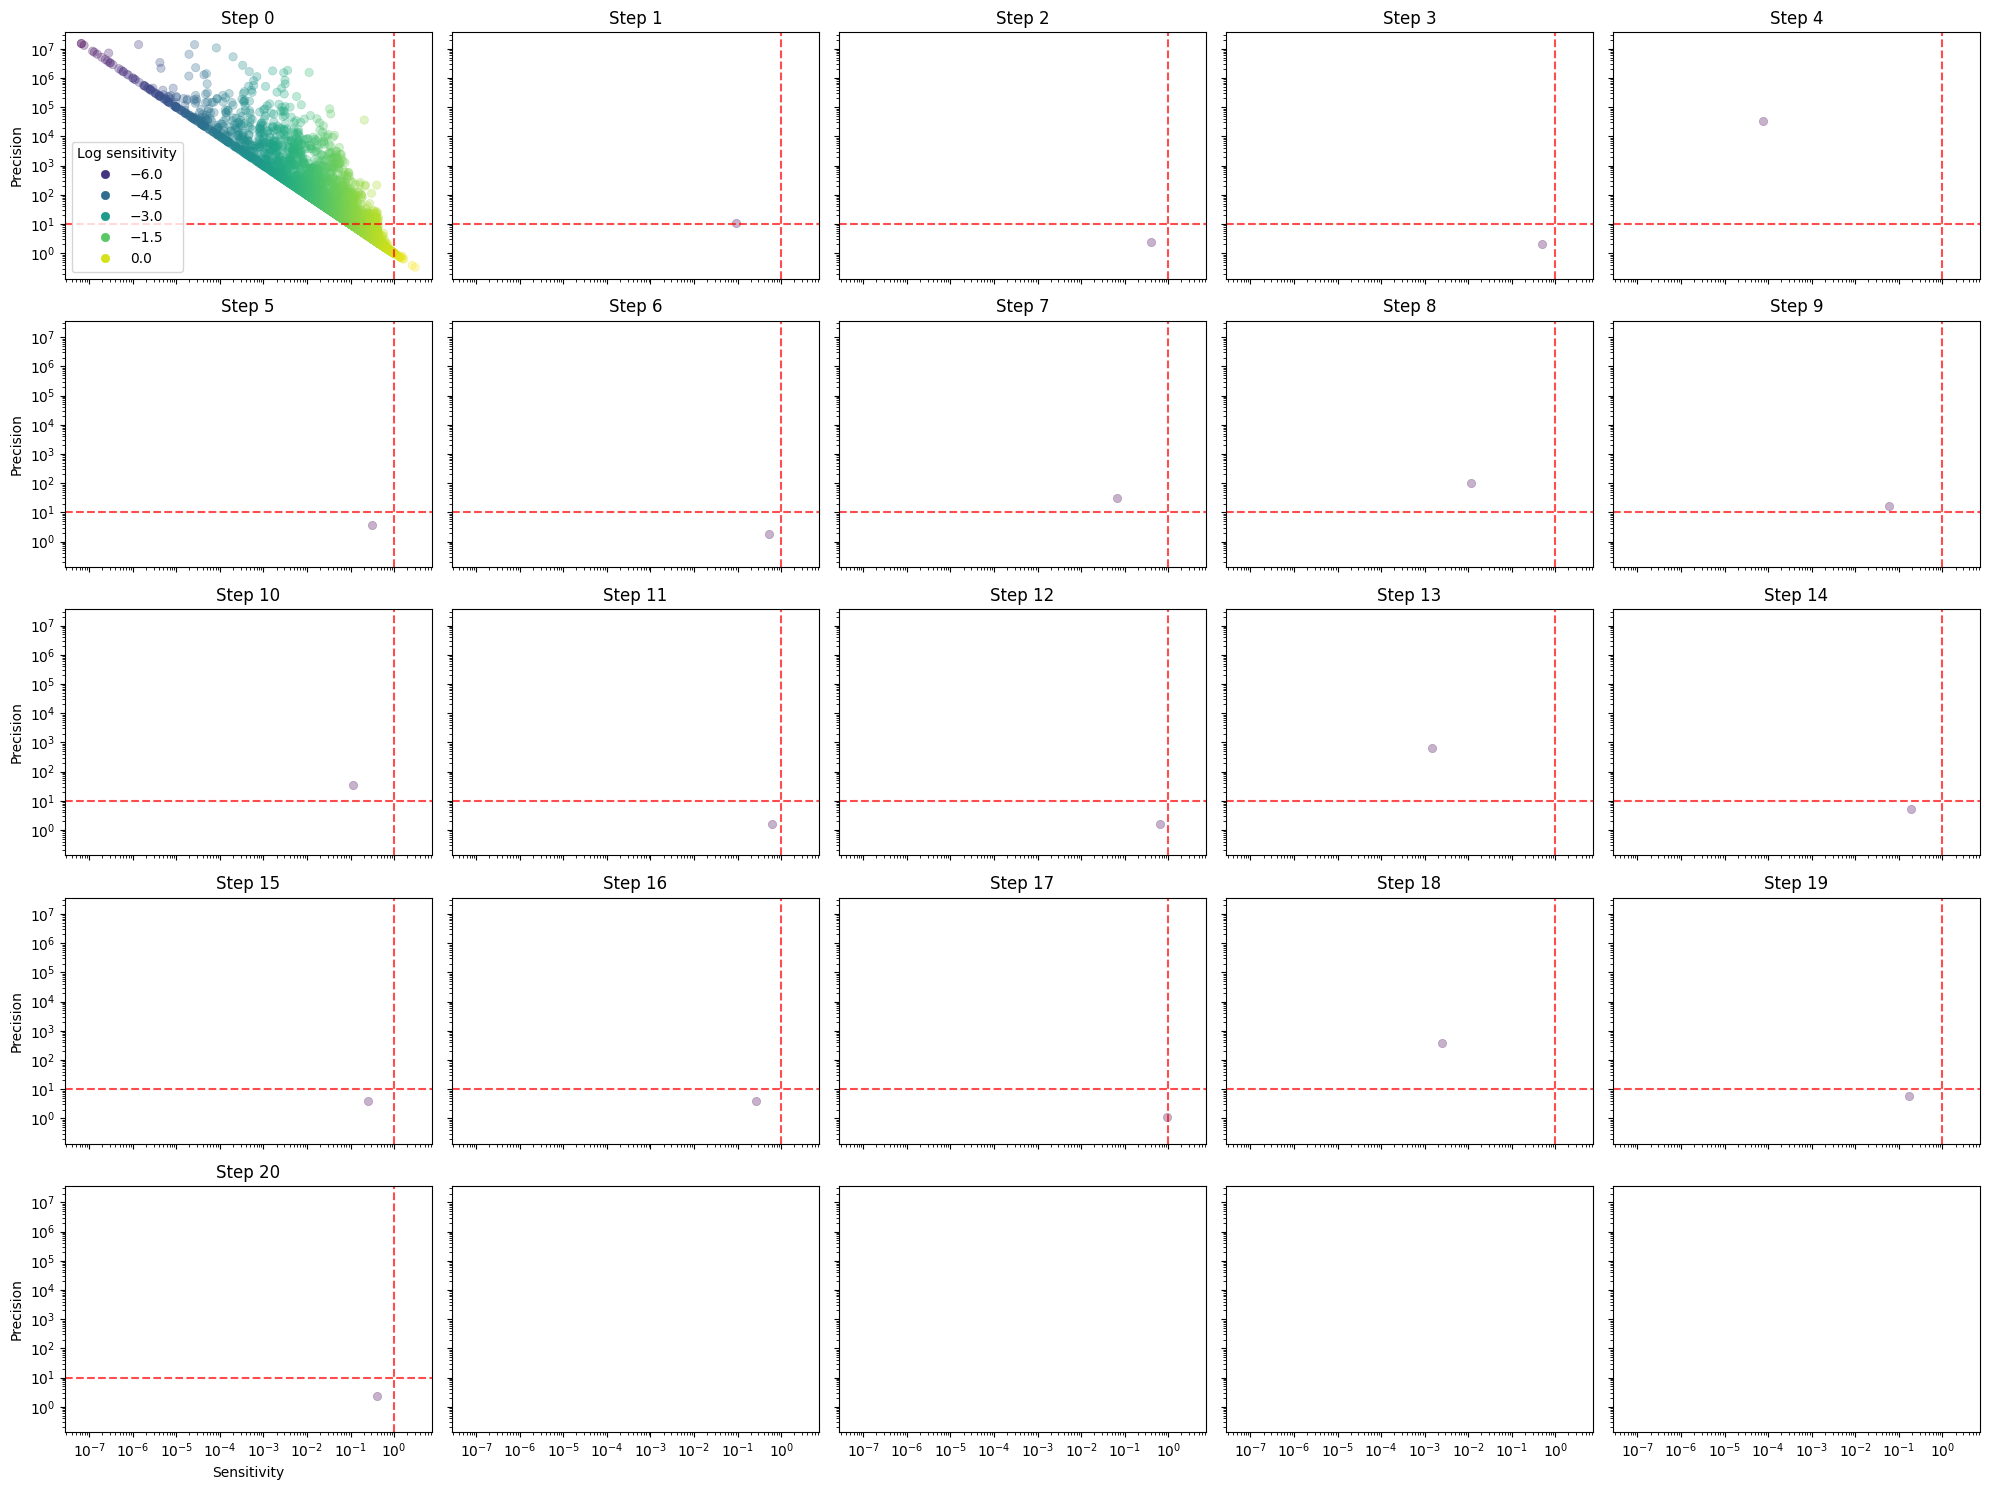

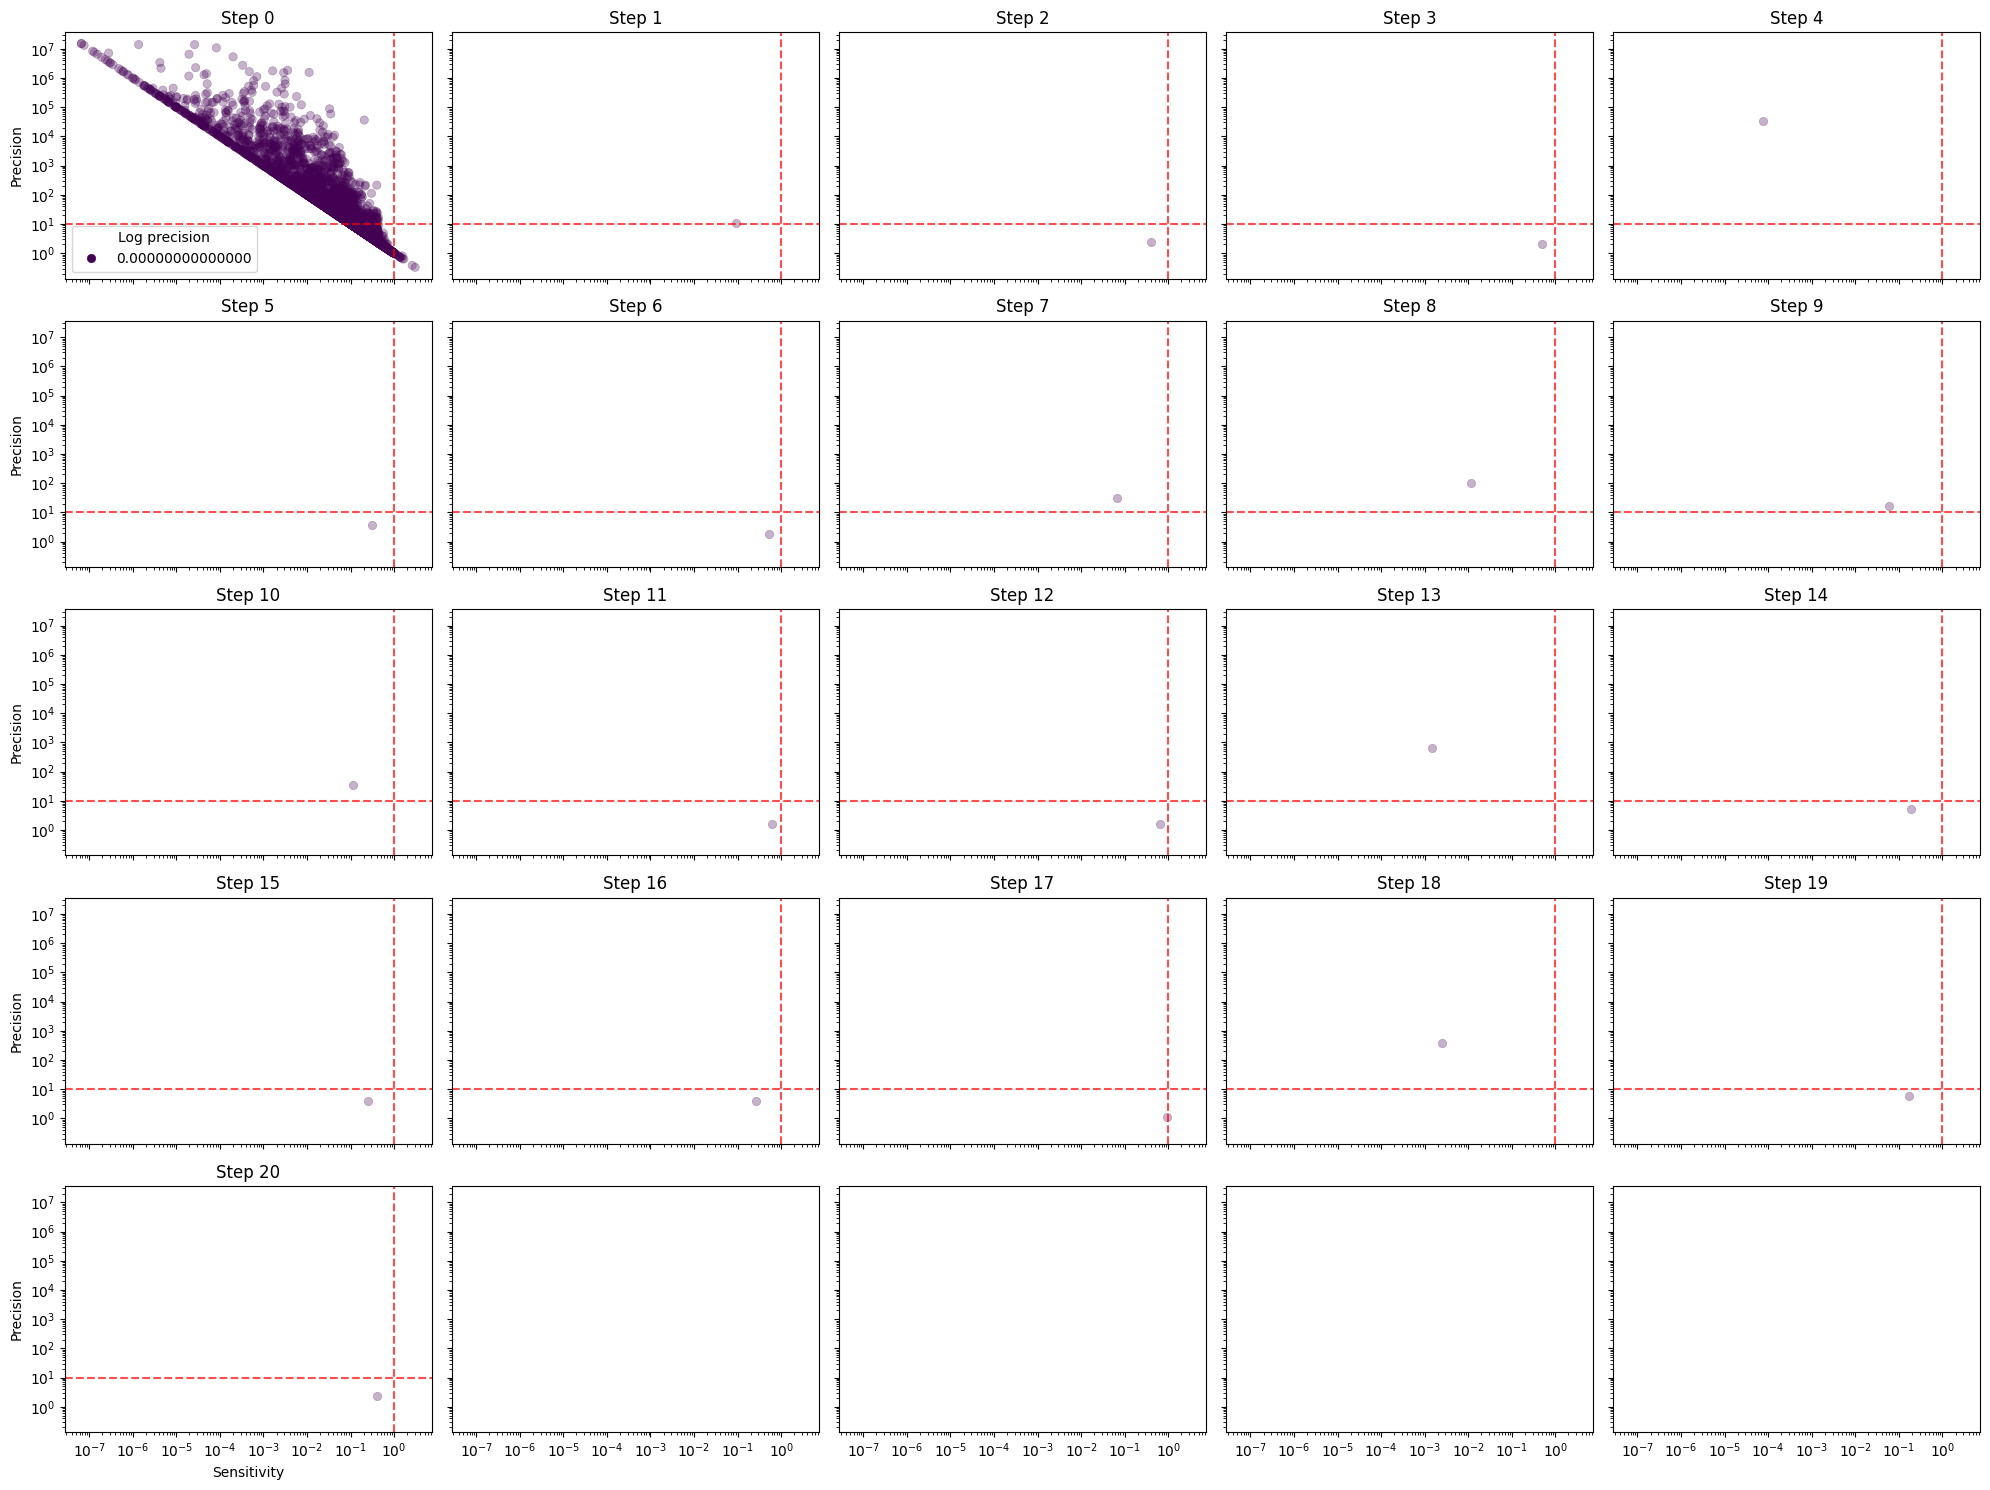

In [ ]:
n_step = int(df_loaded['Step'].max()) + 1
nrows = int(np.ceil(np.sqrt(n_step)))
ncols = int(np.ceil(n_step / nrows))

hues = ['Adaptability', 'Log sensitivity', 'Log precision']
file_namings = ['adaptation', 'sens', 'prec']
for hue, file_naming, palette in zip(hues, file_namings, ['viridis', 'viridis', 'viridis']):
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), 
                            constrained_layout=True, sharex=True, sharey=True)
    for step in range(n_step):
        is_legend = True if step == 0 else False
        step_df = df_loaded[df_loaded['Step'] == step]
        g = sns.scatterplot(data=step_df.sort_values(by=hue), 
                        x='Sensitivity', y='Precision', 
                        hue=hue, ax=axs.flat[step],
                        alpha=0.3, edgecolor=None, palette=palette,
                        legend=is_legend)
        axs.flat[step].set_xscale('log')
        axs.flat[step].set_yscale('log')
        axs.flat[step].set_title(f'Step {step}')

        axs.flat[step].axvline(x=1.0, color='red', linestyle='--', alpha=0.7)
        axs.flat[step].axhline(y=10.0, color='red', linestyle='--', alpha=0.7)

        if is_legend:
            for line in g.legend().get_lines():
                line.set_alpha(1)
            sns.move_legend(g, "lower left", title=hue)

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'{file_naming}.png'), dpi=300)